### TTC delays analysis

**In this Jupyter Notebook we will do the following:**
1. Download our TTC bus delays datasets
2. Do EDA for them and define next steps as a background for statistical analysis
3. Download weather data
4. Combine everything in one merged dataset with count for each category incident

<span style="color:orange">**This is the first part of the TTC delays analysis project, the next will be in another notebook**</span>

In [2]:
!pip install ydata-profiling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from ydata_profiling import ProfileReport

     ---------------------------------------- 0.0/109.4 kB ? eta -:--:--
     --- ------------------------------------ 10.2/109.4 kB ? eta -:--:--
     -------------------------------------- 109.4/109.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/359.5 kB ? eta -:--:--
   ------------------------------------ -- 337.9/359.5 kB 10.6 MB/s eta 0:00:01
   ---------------------------------------- 359.5/359.5 kB 7.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/296.5 kB ? eta -:--:--
   --------------------------------- ------ 245.8/296.5 kB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 296.5/296.5 kB 4.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/667.1 kB ? eta -:--:--
   ---------------------------- ---------- 491.5/667.1 kB 15.5 MB/s eta 0:00:01
   --------------------------------------- 667.1/667.1 kB 

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
#sometimes it's more convenient to look at DFs with these settings, but be careful since in case of thousands rows they can crash your IDE
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)

1. Let's download all of the data about bus delays through their API. We first print all of the files in this package and then download them into this folder. The code in the 2 cells below is from the Toronto Open Data. I already have these files, so they are commented. If you need to download ttc data, just uncomment them

In [5]:
# Toronto Open Data is stored in a CKAN instance. It's APIs are documented here:
# https://docs.ckan.org/en/latest/api/

# To hit our API, you'll be making requests to:
base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

# Datasets are called "packages". Each package can contain many "resources"
# To retrieve the metadata for this package and its resources, use the package name in this page's URL:
url = base_url + "/api/3/action/package_show"
params = { "id": "ttc-bus-delay-data"}
package = requests.get(url, params = params).json()

# To get resource data:
for idx, resource in enumerate(package["result"]["resources"]):
    print('{idx}, {name}, {resource}'.format(idx=idx, name=resource['name'], resource=resource))
    # To get metadata for non datastore_active resources:
    if not resource["datastore_active"]:
        url = base_url + "/api/3/action/resource_show?id=" + resource["id"]
        resource_metadata = requests.get(url).json()
        print(resource_metadata)
        # From here, you can use the "url" attribute to download this file

0, ttc-bus-delay-data-readme, {'cache_last_updated': None, 'cache_url': None, 'created': '2019-07-23T18:10:56.253151', 'datastore_active': False, 'format': 'XLSX', 'hash': '', 'id': '71bb1283-7388-4d23-aa4e-0f393a80abce', 'is_datastore_cache_file': False, 'is_preview': 'False', 'last_modified': '2022-04-05T19:21:58', 'metadata_modified': '2022-04-12T18:45:52.481023', 'mimetype': 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet', 'mimetype_inner': None, 'name': 'ttc-bus-delay-data-readme', 'package_id': 'e271cdae-8788-4980-96ce-6a5c95bc6618', 'position': 0, 'resource_type': None, 'revision_id': 'e90c3e59-7576-4f54-9cb0-6d4375bcc235', 'size': 12839, 'state': 'active', 'url': 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/e271cdae-8788-4980-96ce-6a5c95bc6618/resource/71bb1283-7388-4d23-aa4e-0f393a80abce/download/ttc-bus-delay-data-readme.xlsx', 'url_type': 'upload'}
{'help': 'https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/help_show?name=resource_s

In [6]:
for idx, resource in enumerate(package["result"]["resources"]):
    xlsx_url = resource["url"]
    response = requests.get(xlsx_url)
    
    if response.status_code == 200:
        # Assuming you want to save the XLSX content to a file
        xlsx_filename = f"{resource['name']}.xlsx"
        with open(xlsx_filename, "wb") as file:
            file.write(response.content)
        print(f"XLSX resource downloaded successfully. Check '{xlsx_filename}' file.")
    else:
        print("Failed to download the XLSX resource.")
        break  # Exit the loop if there was an error

XLSX resource downloaded successfully. Check 'ttc-bus-delay-data-readme.xlsx' file.
XLSX resource downloaded successfully. Check 'ttc-bus-delay-data-2014.xlsx' file.
XLSX resource downloaded successfully. Check 'ttc-bus-delay-data-2015.xlsx' file.
XLSX resource downloaded successfully. Check 'ttc-bus-delay-data-2016.xlsx' file.
XLSX resource downloaded successfully. Check 'ttc-bus-delay-data-2017.xlsx' file.
XLSX resource downloaded successfully. Check 'ttc-bus-delay-data-2018.xlsx' file.
XLSX resource downloaded successfully. Check 'ttc-bus-delay-data-2019.xlsx' file.
XLSX resource downloaded successfully. Check 'ttc-bus-delay-data-2020.xlsx' file.
XLSX resource downloaded successfully. Check 'ttc-bus-delay-data-2021.xlsx' file.
XLSX resource downloaded successfully. Check 'ttc-bus-delay-data-2022.xlsx' file.
XLSX resource downloaded successfully. Check 'ttc-bus-delay-data-2023.xlsx' file.
XLSX resource downloaded successfully. Check 'ttc-bus-delay-data-2024.xlsx' file.


2. EDA - let's understand our data

In [7]:
df_readme = pd.read_excel("ttc-bus-delay-data-readme.xlsx")
original_col_width = pd.get_option('display.max_colwidth') #saving the default column width
pd.set_option('display.max_colwidth', None) #changing max col width so we can see the full description below
df_readme

Field Name  \
0  Report Date   
1        Route   
2         Time   
3          Day   
4     Location   
5     Incident   
6    Min Delay   
7      Min Gap   
8    Direction   
9      Vehicle   

                                                                                                                                                                                                                              Description  \
0                                                                                                                                                                          The date (YYYY/MM/DD) when the delay-causing incident occurred   
1                                                                                                                                                                                                             The number of the bus route   
2                                                                                                                                                                      The time (hh:mm:ss AM/PM) when the delay-causing incident occurred   
3                                                                                                                                                                                                                     The name of the day   
4                                                                                                                                                                                              The location of the delay-causing incident   
5                                                                                                                                                                                           The description of the delay-causing incident   
6                                                                                                                                                                            The delay, in minutes, to the schedule for the following bus   
7                                                                                                                                                           The total scheduled time, in minutes, from the bus ahead of the following bus   
8  The direction of the bus route where B,b or BW indicates both ways. (On an east west route, it includes both east and west)                                           NB - northbound, SB - southbound, EB - eastbound, WB - westbound   
9                                                                                                                                                                                                                          Vehicle number   

               Example  
0  2017-06-20 00:00:00  
1                   51  
2             00:35:00  
3               Monday  
4   York Mills Station  
5           Mechanical  
6                   10  
7                   20  
8                    N  
9                 1057

In [8]:
pd.set_option('display.max_colwidth', original_col_width) #changing it back, so our program doesn't crash unexpectedly due to displaying huge dataframes
#this approach is extremely important with max number of columns and rows, but just to be on the safe side let's follow similar guidelines for col width too

Since we have a lot of files, let's loop through them to see their summary statistics

In [9]:
years = np.arange(2014, 2025, 1)
for year in years:
    df = pd.read_excel(f"ttc-bus-delay-data-{year}.xlsx")
    print(year)
    print(df.info())
    print('\n')

2014
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9822 entries, 0 to 9821
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Report Date  9822 non-null   datetime64[ns]
 1   Route        9822 non-null   int64         
 2   Time         9822 non-null   object        
 3   Day          9822 non-null   object        
 4   Location     9814 non-null   object        
 5   Incident     9822 non-null   object        
 6   Min Delay    9819 non-null   float64       
 7   Min Gap      9819 non-null   float64       
 8   Direction    9734 non-null   object        
 9   Vehicle      8641 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 767.5+ KB
None


2015
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6665 entries, 0 to 6664
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         


They all have the same columns, but the number of total delays (rows in df) significantly differ from year to year. Let's isolate count of incidents

In [10]:
for year in years:
    df = pd.read_excel(f"ttc-bus-delay-data-{year}.xlsx")
    print(year, len(df)) #number of delays per year

2014 9822
2015 6665
2016 5326
2017 5300
2018 6969
2019 6743
2020 4282
2021 2832
2022 58707
2023 56207
2024 24238


As we see, the difference is huge - size of the dfs range from 2832 to 58707. For now we can just make some assumptions of either inconsistent filling, covid, or change in reporting rules. Obviously more inverstigating is needed to confirm that

In [11]:
for year in years:
    df = pd.read_excel(f"ttc-bus-delay-data-{year}.xlsx")
    print(year)
    print(df.describe(include="all"))
    print('\n')

2014
                          Report Date        Route      Time      Day  \
count                            9822  9822.000000      9822     9822   
unique                            NaN          NaN      1235        7   
top                               NaN          NaN  08:00:00  Tuesday   
freq                              NaN          NaN       141     1948   
mean    2014-01-16 01:20:29.321930240    86.089188       NaN      NaN   
min               2014-01-01 00:00:00     1.000000       NaN      NaN   
25%               2014-01-07 00:00:00    36.000000       NaN      NaN   
50%               2014-01-16 00:00:00    60.000000       NaN      NaN   
75%               2014-01-24 00:00:00   105.000000       NaN      NaN   
max               2014-01-31 00:00:00   909.000000       NaN      NaN   
std                               NaN    89.551231       NaN      NaN   

          Location    Incident    Min Delay      Min Gap Direction  \
count         9814        9822  9819.000000  981

The average delay in minutes (min delay mean) has been consistently increasing over the years. However, we cannot be sure about how reliable this conclusion is due to a significant difference in counts of delays

In [12]:
for year in years:
    df = pd.read_excel('ttc-bus-delay-data-{}.xlsx'.format(year))
    print(year, df['Incident'].value_counts())
    print('\n')

2014 Incident
Mechanical             5401
Utilized Off Route     1356
Late Leaving Garage    1148
General Delay          1010
Investigation           536
Diversion               267
Emergency Services      104
Name: count, dtype: int64


2015 Incident
Mechanical             2961
Late Leaving Garage    1325
Utilized Off Route     1074
Investigation           480
General Delay           475
Diversion               247
Emergency Services      103
Name: count, dtype: int64


2016 Incident
Mechanical             2342
Late Leaving Garage     864
Utilized Off Route      845
Investigation           486
General Delay           445
Diversion               257
Emergency Services       87
Name: count, dtype: int64


2017 Incident
Mechanical             2164
Late Leaving Garage    1007
Utilized Off Route      975
Investigation           499
General Delay           287
Diversion               262
Emergency Services      106
Name: count, dtype: int64


2018 Incident
Mechanical             2246
Late L

Operations as a category appeared only in 2021, and in 2022 was the most common category. This confirms that they changed their reporting rules. Another thing we need to account for is Covid, which might have influenced 2020 and 2021 since they have the least incidents from all other years (quarantine -> less public transport usage -> less delays). That's why we decided to focus on 2022 and 2023 - they have similar counts, distributions, and they are not affected by covid as much as previous years

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

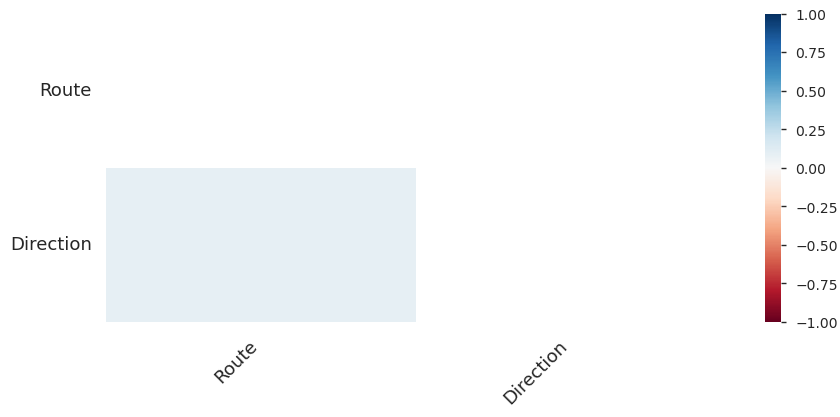

In [13]:
df22 = pd.read_excel("ttc-bus-delay-data-2022.xlsx")
profile22 = ProfileReport(df22, title="Profiling Report TTC bus delays 2022")
profile22

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

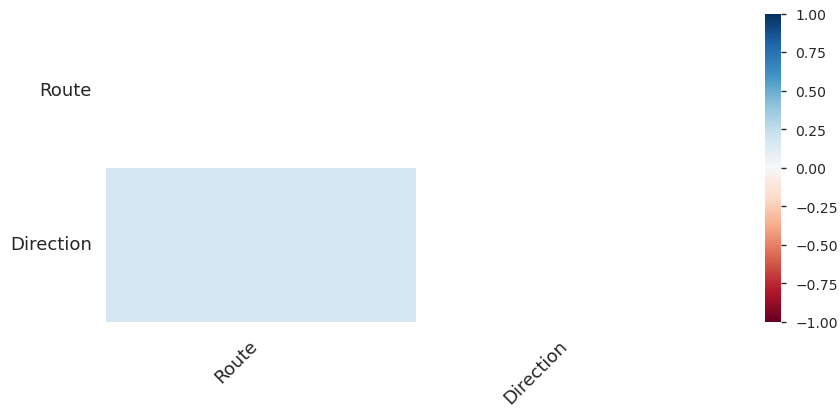

In [14]:
df23 = pd.read_excel("ttc-bus-delay-data-2023.xlsx")
profile23 = ProfileReport(df23, title="Profiling Report TTC bus delays 2023")
profile23

### Notes
1. Delays are substantial - the median is 11 minutes
2. The mean of the delays is way higher than the median, which indicates a lot of outliers which skew the distribution
3. Lots of missing values in direction - not a problem for us, it's not an important column, so we can just drop it
4. A bit of missing values in route, we can drop these rows if anything or drop the column too
5. The most important columns IMO are date, time, day, location, incident, and min delay

### Next steps
1. To find out how many delays are under 0 or 5 minutes
2. To print all of the incident values and get additional explanation for them if needed
3. To compare all other years of data (to understand if it's the same format)

In [15]:
df22[df22['Min Delay'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2818 entries, 0 to 58693
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2818 non-null   datetime64[ns]
 1   Route      2585 non-null   object        
 2   Time       2818 non-null   object        
 3   Day        2818 non-null   object        
 4   Location   2818 non-null   object        
 5   Incident   2818 non-null   object        
 6   Min Delay  2818 non-null   int64         
 7   Min Gap    2818 non-null   int64         
 8   Direction  1604 non-null   object        
 9   Vehicle    2818 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 242.2+ KB


In [16]:
df23[df23['Min Delay'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 4590 entries, 5 to 56205
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4590 non-null   datetime64[ns]
 1   Route      4115 non-null   object        
 2   Time       4590 non-null   object        
 3   Day        4590 non-null   object        
 4   Location   4590 non-null   object        
 5   Incident   4590 non-null   object        
 6   Min Delay  4590 non-null   int64         
 7   Min Gap    4590 non-null   int64         
 8   Direction  2823 non-null   object        
 9   Vehicle    4590 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 394.5+ KB


In [17]:
df22[df22['Min Delay'] <= 5].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5602 entries, 0 to 58702
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5602 non-null   datetime64[ns]
 1   Route      5348 non-null   object        
 2   Time       5602 non-null   object        
 3   Day        5602 non-null   object        
 4   Location   5602 non-null   object        
 5   Incident   5602 non-null   object        
 6   Min Delay  5602 non-null   int64         
 7   Min Gap    5602 non-null   int64         
 8   Direction  3868 non-null   object        
 9   Vehicle    5602 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 481.4+ KB


In [18]:
df23[df23['Min Delay'] <= 5].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6542 entries, 4 to 56205
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6542 non-null   datetime64[ns]
 1   Route      6060 non-null   object        
 2   Time       6542 non-null   object        
 3   Day        6542 non-null   object        
 4   Location   6542 non-null   object        
 5   Incident   6542 non-null   object        
 6   Min Delay  6542 non-null   int64         
 7   Min Gap    6542 non-null   int64         
 8   Direction  4410 non-null   object        
 9   Vehicle    6542 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 562.2+ KB


Not so many short delays. As an option, we can just drop the rows below a certain threshold (5 minutes, 10 minutes?) to work only with significant delays

In [19]:
df22['Incident'].value_counts()

Incident
Operations - Operator               19583
Mechanical                          16469
Collision - TTC                      3512
Security                             3374
Utilized Off Route                   3240
General Delay                        3218
Diversion                            2883
Emergency Services                   2421
Cleaning - Unsanitary                1561
Investigation                         906
Vision                                708
Road Blocked - NON-TTC Collision      624
Held By                               162
Late Entering Service                  40
Cleaning - Disinfection                 6
Name: count, dtype: int64

In [20]:
df23['Incident'].value_counts()

Incident
Mechanical                          19235
Operations - Operator               11360
Security                             4807
Collision - TTC                      3909
Diversion                            3805
General Delay                        3199
Emergency Services                   3017
Utilized Off Route                   2363
Cleaning - Unsanitary                2152
Investigation                        1247
Vision                                787
Road Blocked - NON-TTC Collision      249
Held By                                77
Name: count, dtype: int64

The main 2 reasons are "Mechanical" and "Operations - Operator"

3. Since we work with 2022 and 2023, we need to download weather data for these 2 years

In [21]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 43.7001,
	"longitude": -79.4163,
	"start_date": "2022-01-01",
	"end_date": "2023-12-31",
	"daily": ["weather_code", "temperature_2m_mean", "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max"],
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(1).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(2).ValuesAsNumpy()
daily_rain_sum = daily.Variables(3).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(4).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(5).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(6).ValuesAsNumpy()
daily_wind_gusts_10m_max = daily.Variables(7).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["weather_code"] = daily_weather_code
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["rain_sum"] = daily_rain_sum
daily_data["snowfall_sum"] = daily_snowfall_sum
daily_data["precipitation_hours"] = daily_precipitation_hours
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max

daily_dataframe = pd.DataFrame(data = daily_data)

Coordinates 43.6906852722168°N -79.4117431640625°E
Elevation 175.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s


In [22]:
daily_dataframe

date  weather_code  temperature_2m_mean  \
0   2022-01-01 04:00:00+00:00          73.0             2.319333   
1   2022-01-02 04:00:00+00:00          73.0            -6.297333   
2   2022-01-03 04:00:00+00:00           3.0            -9.074418   
3   2022-01-04 04:00:00+00:00           3.0            -2.722333   
4   2022-01-05 04:00:00+00:00          51.0             1.611000   
..                        ...           ...                  ...   
725 2023-12-27 04:00:00+00:00          63.0             6.240167   
726 2023-12-28 04:00:00+00:00          53.0             6.121417   
727 2023-12-29 04:00:00+00:00          55.0             5.406834   
728 2023-12-30 04:00:00+00:00          51.0             0.463083   
729 2023-12-31 04:00:00+00:00          73.0             0.008917   

     precipitation_sum   rain_sum  snowfall_sum  precipitation_hours  \
0             2.800000   0.400000          1.68                  9.0   
1             6.000000   0.000000          4.20                 14.0   
2             0.000000   0.000000          0.00                  0.0   
3             0.000000   0.000000          0.00                  0.0   
4             0.800000   0.800000          0.00                  5.0   
..                 ...        ...           ...                  ...   
725          20.000002  20.000002          0.00                 19.0   
726           3.800000   3.800000          0.00                 14.0   
727           5.800000   5.800000          0.00                 18.0   
728           0.200000   0.200000          0.00                  2.0   
729           2.000000   0.200000          1.26                  9.0   

     wind_speed_10m_max  wind_gusts_10m_max  
0             20.907913           36.000000  
1             22.264771           39.239998  
2             16.981165           29.160000  
3             21.398056           37.079998  
4             35.221176           64.079994  
..                  ...                 ...  
725           17.253731           31.319998  
726           15.790833           28.440001  
727           15.986595           29.879999  
728           16.965895           30.960001  
729           13.570615           25.919998  

[730 rows x 9 columns]

4. Merge everything in one df
- Merge 2022 and 2023 into one df
- Get dummy variables for each reason of delay
- Group by days (each row represents all of the delays from one day and shows count of delays for each reason)
- Merge it with weather data

In [23]:
[df22['Incident'].unique().size, df23['Incident'].unique().size]

[15, 13]

In [24]:
merged_delays_df = pd.concat([df22, df23], ignore_index=True)

In [25]:
merged_delays_df[58704:58720] #to check the border

Date Route   Time       Day                Location  \
58704 2022-12-31    72  23:56  Saturday  LOWER SHERBOURNE AND L   
58705 2022-12-31    22  00:17  Saturday            BINGHAM LOOP   
58706 2022-12-31     7  00:28  Saturday        BATHURST STATION   
58707 2023-01-01    91  02:30    Sunday   WOODBINE AND MORTIMER   
58708 2023-01-01    69  02:34    Sunday          WARDEN STATION   
58709 2023-01-01    35  03:06    Sunday            JANE STATION   
58710 2023-01-01   900  03:14    Sunday         KIPLING STATION   
58711 2023-01-01    85  03:43    Sunday          MEADOWALE LOOP   
58712 2023-01-01    40  03:47    Sunday         KIPLING STATION   
58713 2023-01-01   336  03:52    Sunday        FINCH AND ALNESS   
58714 2023-01-01    52  04:25    Sunday      LAWRENCE AND YONGE   
58715 2023-01-01    24  04:35    Sunday       DANFORTH AND MAIN   
58716 2023-01-01    36  05:18    Sunday        FINCH AND ALNESS   
58717 2023-01-01    36  05:50    Sunday           FINCH STATION   
58718 2023-01-01   300  06:04    Sunday       DANFOTH AND LOGAN   
58719 2023-01-01   320  06:07    Sunday            STEELES LOOP   

                    Incident  Min Delay  Min Gap Direction  Vehicle  
58704               Security         18       36         N     8493  
58705  Cleaning - Unsanitary         10       20         S     8582  
58706          General Delay         10       20         N     8354  
58707              Diversion         81      111       NaN     8772  
58708               Security         22       44         S     8407  
58709  Cleaning - Unsanitary         30       60         N     1051  
58710               Security         17       17       NaN     3334  
58711               Security          1        1       NaN     1559  
58712     Emergency Services          0        0       NaN        0  
58713              Diversion        138      168       NaN     9220  
58714     Emergency Services         30       60         E     3520  
58715  Cleaning - Unsanitary         20       40         W     8404  
58716              Diversion        334      344       NaN     3524  
58717  Cleaning - Unsanitary         11       26         W     3561  
58718              Diversion        138      148         E     3339  
58719     Emergency Services          6       12         E     3462

In [26]:
merged_delays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114914 entries, 0 to 114913
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       114914 non-null  datetime64[ns]
 1   Route      113960 non-null  object        
 2   Time       114914 non-null  object        
 3   Day        114914 non-null  object        
 4   Location   114914 non-null  object        
 5   Incident   114914 non-null  object        
 6   Min Delay  114914 non-null  int64         
 7   Min Gap    114914 non-null  int64         
 8   Direction  94894 non-null   object        
 9   Vehicle    114914 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 8.8+ MB


In [27]:
merged_df_dummies = pd.get_dummies(merged_delays_df, columns=['Incident'])

In [28]:
merged_df_dummies.head()

Date Route   Time       Day                Location  Min Delay  \
0 2022-01-01   320  02:00  Saturday        YONGE AND DUNDAS          0   
1 2022-01-01   325  02:00  Saturday  OVERLEA AND THORCLIFFE        131   
2 2022-01-01   320  02:00  Saturday       YONGE AND STEELES         17   
3 2022-01-01   320  02:07  Saturday       YONGE AND STEELES          4   
4 2022-01-01   320  02:13  Saturday       YONGE AND STEELES          4   

   Min Gap Direction  Vehicle  Incident_Cleaning - Disinfection  ...  \
0        0       NaN     8531                             False  ...   
1      161         W     8658                             False  ...   
2       20         S        0                             False  ...   
3       11         S        0                             False  ...   
4        8         S        0                             False  ...   

   Incident_General Delay  Incident_Held By  Incident_Investigation  \
0                    True             False                   False   
1                   False             False                   False   
2                   False             False                   False   
3                   False             False                   False   
4                   False             False                   False   

   Incident_Late Entering Service  Incident_Mechanical  \
0                           False                False   
1                           False                False   
2                           False                False   
3                           False                False   
4                           False                False   

   Incident_Operations - Operator  Incident_Road Blocked - NON-TTC Collision  \
0                           False                                      False   
1                           False                                      False   
2                            True                                      False   
3                            True                                      False   
4                            True                                      False   

   Incident_Security  Incident_Utilized Off Route  Incident_Vision  
0              False                        False            False  
1              False                        False            False  
2              False                        False            False  
3              False                        False            False  
4              False                        False            False  

[5 rows x 24 columns]

In [29]:
merged_df_dummies.columns

Index(['Date', 'Route', 'Time', 'Day', 'Location', 'Min Delay', 'Min Gap',
       'Direction', 'Vehicle', 'Incident_Cleaning - Disinfection',
       'Incident_Cleaning - Unsanitary', 'Incident_Collision - TTC',
       'Incident_Diversion', 'Incident_Emergency Services',
       'Incident_General Delay', 'Incident_Held By', 'Incident_Investigation',
       'Incident_Late Entering Service', 'Incident_Mechanical',
       'Incident_Operations - Operator',
       'Incident_Road Blocked - NON-TTC Collision', 'Incident_Security',
       'Incident_Utilized Off Route', 'Incident_Vision'],
      dtype='object')

In [30]:
incident_columns = ['Incident_Cleaning - Disinfection',
       'Incident_Cleaning - Unsanitary', 'Incident_Collision - TTC',
       'Incident_Diversion', 'Incident_Emergency Services',
       'Incident_General Delay', 'Incident_Held By', 'Incident_Investigation',
       'Incident_Late Entering Service', 'Incident_Mechanical',
       'Incident_Operations - Operator',
       'Incident_Road Blocked - NON-TTC Collision', 'Incident_Security',
       'Incident_Utilized Off Route', 'Incident_Vision']

In [31]:
df_daily = merged_df_dummies.groupby('Date')[incident_columns].sum().reset_index()

In [32]:
df_daily['Total Incidents'] = df_daily[incident_columns].sum(axis=1)

In [33]:
merged_df = pd.concat([daily_dataframe, df_daily], axis=1)

In [34]:
merged_df = merged_df.rename(columns={'date': 'date_from_weather'})
merged_df

date_from_weather  weather_code  temperature_2m_mean  \
0   2022-01-01 04:00:00+00:00          73.0             2.319333   
1   2022-01-02 04:00:00+00:00          73.0            -6.297333   
2   2022-01-03 04:00:00+00:00           3.0            -9.074418   
3   2022-01-04 04:00:00+00:00           3.0            -2.722333   
4   2022-01-05 04:00:00+00:00          51.0             1.611000   
..                        ...           ...                  ...   
725 2023-12-27 04:00:00+00:00          63.0             6.240167   
726 2023-12-28 04:00:00+00:00          53.0             6.121417   
727 2023-12-29 04:00:00+00:00          55.0             5.406834   
728 2023-12-30 04:00:00+00:00          51.0             0.463083   
729 2023-12-31 04:00:00+00:00          73.0             0.008917   

     precipitation_sum   rain_sum  snowfall_sum  precipitation_hours  \
0             2.800000   0.400000          1.68                  9.0   
1             6.000000   0.000000          4.20                 14.0   
2             0.000000   0.000000          0.00                  0.0   
3             0.000000   0.000000          0.00                  0.0   
4             0.800000   0.800000          0.00                  5.0   
..                 ...        ...           ...                  ...   
725          20.000002  20.000002          0.00                 19.0   
726           3.800000   3.800000          0.00                 14.0   
727           5.800000   5.800000          0.00                 18.0   
728           0.200000   0.200000          0.00                  2.0   
729           2.000000   0.200000          1.26                  9.0   

     wind_speed_10m_max  wind_gusts_10m_max       Date  ...  Incident_Held By  \
0             20.907913           36.000000 2022-01-01  ...                 0   
1             22.264771           39.239998 2022-01-02  ...                 0   
2             16.981165           29.160000 2022-01-03  ...                 0   
3             21.398056           37.079998 2022-01-04  ...                 0   
4             35.221176           64.079994 2022-01-05  ...                 0   
..                  ...                 ...        ...  ...               ...   
725           17.253731           31.319998 2023-12-27  ...                 0   
726           15.790833           28.440001 2023-12-28  ...                 0   
727           15.986595           29.879999 2023-12-29  ...                 0   
728           16.965895           30.960001 2023-12-30  ...                 2   
729           13.570615           25.919998 2023-12-31  ...                 0   

     Incident_Investigation  Incident_Late Entering Service  \
0                         1                               0   
1                         1                               0   
2                         4                               0   
3                         0                               0   
4                         1                               0   
..                      ...                             ...   
725                       5                               0   
726                       1                               0   
727                       3                               0   
728                       5                               0   
729                       1                               0   

     Incident_Mechanical  Incident_Operations - Operator  \
0                     21                              87   
1                     41                              64   
2                     55                             182   
3                     36                             157   
4                     48                             205   
..                   ...                             ...   
725                   62                              70   
726                   55                              31   
727                   60                              70   


In [35]:
merged_df = merged_df.rename(columns={'Date': 'date_from_ttc'})
merged_df

date_from_weather  weather_code  temperature_2m_mean  \
0   2022-01-01 04:00:00+00:00          73.0             2.319333   
1   2022-01-02 04:00:00+00:00          73.0            -6.297333   
2   2022-01-03 04:00:00+00:00           3.0            -9.074418   
3   2022-01-04 04:00:00+00:00           3.0            -2.722333   
4   2022-01-05 04:00:00+00:00          51.0             1.611000   
..                        ...           ...                  ...   
725 2023-12-27 04:00:00+00:00          63.0             6.240167   
726 2023-12-28 04:00:00+00:00          53.0             6.121417   
727 2023-12-29 04:00:00+00:00          55.0             5.406834   
728 2023-12-30 04:00:00+00:00          51.0             0.463083   
729 2023-12-31 04:00:00+00:00          73.0             0.008917   

     precipitation_sum   rain_sum  snowfall_sum  precipitation_hours  \
0             2.800000   0.400000          1.68                  9.0   
1             6.000000   0.000000          4.20                 14.0   
2             0.000000   0.000000          0.00                  0.0   
3             0.000000   0.000000          0.00                  0.0   
4             0.800000   0.800000          0.00                  5.0   
..                 ...        ...           ...                  ...   
725          20.000002  20.000002          0.00                 19.0   
726           3.800000   3.800000          0.00                 14.0   
727           5.800000   5.800000          0.00                 18.0   
728           0.200000   0.200000          0.00                  2.0   
729           2.000000   0.200000          1.26                  9.0   

     wind_speed_10m_max  wind_gusts_10m_max date_from_ttc  ...  \
0             20.907913           36.000000    2022-01-01  ...   
1             22.264771           39.239998    2022-01-02  ...   
2             16.981165           29.160000    2022-01-03  ...   
3             21.398056           37.079998    2022-01-04  ...   
4             35.221176           64.079994    2022-01-05  ...   
..                  ...                 ...           ...  ...   
725           17.253731           31.319998    2023-12-27  ...   
726           15.790833           28.440001    2023-12-28  ...   
727           15.986595           29.879999    2023-12-29  ...   
728           16.965895           30.960001    2023-12-30  ...   
729           13.570615           25.919998    2023-12-31  ...   

     Incident_Held By  Incident_Investigation  Incident_Late Entering Service  \
0                   0                       1                               0   
1                   0                       1                               0   
2                   0                       4                               0   
3                   0                       0                               0   
4                   0                       1                               0   
..                ...                     ...                             ...   
725                 0                       5                               0   
726                 0                       1                               0   
727                 0                       3                               0   
728                 2                       5                               0   
729                 0                       1                               0   

     Incident_Mechanical  Incident_Operations - Operator  \
0                     21                              87   
1                     41                              64   
2                     55                             182   
3                     36                             157   
4                     48                             205   
..                   ...                             ...   
725                   62                              70   
726                   55                              31   
727                   60